## Cloudless Mosaic

This tutorial constructs a *cloudless mosaic* (also known as a composite) from a time series of satellite images. We'll see the following:

* Find a time series of images at a particular point on Earth
* Stack those images together into a single array
* Compute the cloudless mosaic by taking a median
* Visualize the results

This example uses [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) data. The techniques used here apply equally well to other remote-sensing datasets.

In [1]:
import numpy as np
import xarray as xr

import rasterio.features
import rioxarray
import stackstac
import pystac_client
import planetary_computer

import pyproj
from shapely.ops import transform
from shapely.geometry import Polygon

import xrspatial.multispectral as ms

from dask_gateway import GatewayCluster

### Create a Dask cluster

We're going to process a large amount of data. To cut down on the execution time, we'll use a Dask cluster to do the computation in parallel, adaptively scaling to add and remove workers as needed. See [Scale With Dask](../quickstarts/scale-with-dask.ipynb) for more on using Dask.

In [2]:
cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.

client = cluster.get_client()

cluster.adapt(minimum=4, maximum=24)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.5102a6a8f8b448ea93e0a561459e4128/status


### Discover data

In this example, we define our area of interest as a GeoJSON object. It's near Redmond, Washington.

In [3]:
coords =[[175.9540924324072,-39.79467075565404],
        [175.945114873355,-39.5925815994339],
        [175.7466289836702,-39.59528350422168],
        [175.7518945072953,-39.79792833072585],
        [175.9540924324072,-39.79467075565404]]

# bbox = rasterio.features.bounds(area_of_interest)
pol = Polygon(coords)

# (minx, miny, maxx, maxy)
bbox = pol.bounds

Using `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters.

In [4]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bbox,
    datetime="2016-01-01/2022-01-01",
    collections=["sentinel-2-l2a"],
    limit=500,  # fetch items in batches of 500
    query={"eo:cloud_cover": {"lt": 25}},
)

items = list(search.get_items())
print(len(items))

379


So 138 items match our search requirements, over space, time, and cloudiness. Those items will still have *some* clouds over portions of the scenes, though. To create our cloudless mosaic, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/) and then reduce the time-series of images down to a single image.

In [5]:
%%time
signed_items = []
for item in items:
    item.clear_links()
    signed_items.append(planetary_computer.sign(item).to_dict())

CPU times: user 413 ms, sys: 0 ns, total: 413 ms
Wall time: 1.04 s


In [6]:
data = (
    stackstac.stack(
        signed_items,
        assets=["B02","B03","B04","B08","SCL"],
        chunksize=4096,
        resolution=10,
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
)

# Get bounding box in projection of data
project = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:4326'), pyproj.CRS(data.crs), always_xy=True).transform
pol_utm = transform(project, pol)
minx, miny, maxx, maxy = pol_utm.bounds

# Subset data, mask clouds
data = data.sel(x=slice(minx, maxx), y=slice(maxy,miny))
data = data.where(~data.isel(band=4).isin([3,8,9])).isel(band=slice(0,4))
data

/srv/conda/envs/notebook/lib/python3.8/site-packages/stackstac/accumulate_metadata.py:151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  props_arr = np.squeeze(np.array(props))


,Array,Chunk
Bytes,46.94 GiB,31.71 MiB
Shape,"(379, 4, 2300, 1807)","(1, 1, 2300, 1807)"
Count,216067 Tasks,1516 Chunks
Type,float64,numpy.ndarray


Since the data matching our query isn't too large we can persist it in distributed memory. Once in memory, subsequent operations will be much faster.

In [7]:
data = data.persist()

In [8]:
pan = data.mean(dim='band')

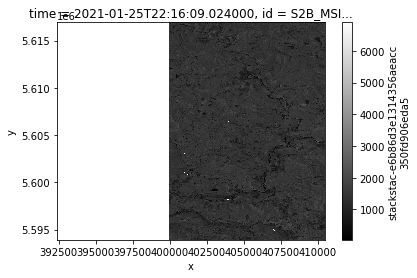

In [86]:
pan.isel(time=156).plot.imshow(cmap='gray')

## Number of groups

In [100]:
pan.groupby("time.year").count().mean(dim=['x','y']).to_numpy()

array([ 4.0256091 , 15.71408195, 10.07209451, 15.91148096, 24.18905272,
       13.87514449])

In [9]:
import pandas as pd
year_season_idx = pd.MultiIndex.from_arrays([pan['time.year'].to_numpy(), pan['time.season'].to_numpy()])
pan.coords['year_season'] = ('time', year_season_idx)

pan.groupby("year_season").count().mean(dim=['x','y']).to_numpy()

array([ 1.21814634,  2.7751262 ,  0.9964356 ,  1.78414668,  1.45581723,
        6.8883434 ,  5.58765429,  6.77450446,  4.6294632 ,  5.53661413,
        4.50453695,  5.05448136,  6.68207358,  6.25903852,  6.40547869,
        9.0511056 , 12.75227882, 12.14380934,  8.10924954,  4.35734366,
        7.48229446,  8.12584827,  8.79311951,  1.95359736])

In [16]:
set(list(pan.year_season.to_numpy()))

{(2016, 'DJF'),
 (2016, 'JJA'),
 (2016, 'MAM'),
 (2016, 'SON'),
 (2017, 'DJF'),
 (2017, 'JJA'),
 (2017, 'MAM'),
 (2017, 'SON'),
 (2018, 'DJF'),
 (2018, 'JJA'),
 (2018, 'MAM'),
 (2018, 'SON'),
 (2019, 'DJF'),
 (2019, 'JJA'),
 (2019, 'MAM'),
 (2019, 'SON'),
 (2020, 'DJF'),
 (2020, 'JJA'),
 (2020, 'MAM'),
 (2020, 'SON'),
 (2021, 'DJF'),
 (2021, 'JJA'),
 (2021, 'MAM'),
 (2021, 'SON')}

## Grouped Yearly

In [108]:
grouped = pan.groupby("time.year").median()

In [109]:
grouped = grouped.rename('Panchromatic')
grouped = grouped.rio.write_crs(pyproj.CRS(data.crs).to_string())

Let's convert each of those arrays to a true-color image and plot the results as a grid.

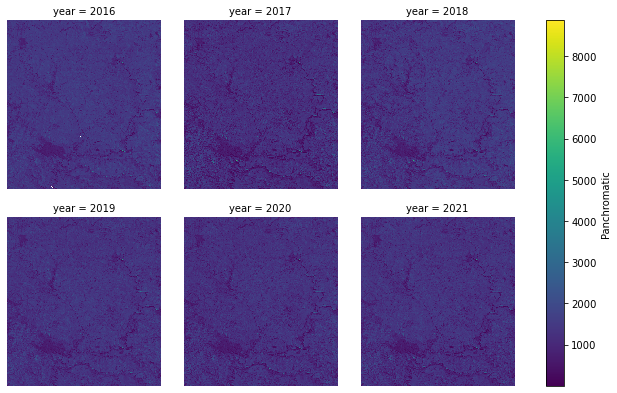

In [110]:
import matplotlib.pyplot as plt

g = grouped.plot.imshow(x="x", y="y", col="year", col_wrap=3)
for ax in g.axes.flat:
    ax.set_axis_off()

In [111]:
for y in grouped.year.to_numpy():
    grouped.sel(year=y).rio.to_raster(f's2_l2_{y}0601.tif')

In [ ]:
del grouped

## Grouped Yearly and Seasonally

In [17]:
import pandas as pd
year_season_idx = pd.MultiIndex.from_arrays([pan['time.year'].to_numpy(), pan['time.season'].to_numpy()])
pan.coords['year_season'] = ('time', year_season_idx)

In [18]:
grouped = pan.groupby('year_season').median()

In [19]:
grouped = grouped.rename('Panchromatic')
grouped = grouped.rio.write_crs(pyproj.CRS(data.crs).to_string())

Let's convert each of those arrays to a true-color image and plot the results as a grid.

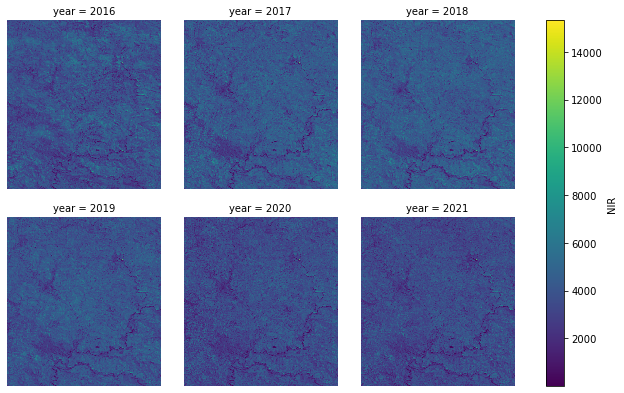

In [47]:
import matplotlib.pyplot as plt

g = grouped.plot.imshow(x='x', y='y', col='year_season', col_wrap=3)
for ax in g.axes.flat:
    ax.set_axis_off()

In [21]:
season_mid = {'DJF':'01','MAM':'04','JJA':'07','SON':'10'}

for i in grouped.year_season.to_numpy():
    y,s = i
    m = season_mid[s]
    out_name = f's2_l2_{y}{m}15.tif'
    grouped.sel(year_season=i).rio.to_raster(out_name)
    print(out_name)

s2_l2_20160115.tif
s2_l2_20160415.tif
s2_l2_20160715.tif
s2_l2_20161015.tif
s2_l2_20170115.tif
s2_l2_20170415.tif
s2_l2_20170715.tif
s2_l2_20171015.tif
s2_l2_20180115.tif
s2_l2_20180415.tif
s2_l2_20180715.tif
s2_l2_20181015.tif
s2_l2_20190115.tif
s2_l2_20190415.tif
s2_l2_20190715.tif
s2_l2_20191015.tif
s2_l2_20200115.tif
s2_l2_20200415.tif
s2_l2_20200715.tif
s2_l2_20201015.tif
s2_l2_20210115.tif
s2_l2_20210415.tif
s2_l2_20210715.tif
s2_l2_20211015.tif


### Learn more

To learn more about using the the Planetary Computer's STAC API, see [Reading data from the STAC API](../quickstarts/reading-stac.ipynb). To learn more about Dask, see [Scaling with Dask](../quickstarts/scale-with-dask.ipynb).